In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14130, done.
remote: Total 14130 (delta 0), reused 0 (delta 0), pack-reused 14130
Receiving objects: 100% (14130/14130), 13.53 MiB | 24.74 MiB/s, done.
Resolving deltas: 100% (9717/9717), done.


In [ ]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 182 kB 5.7 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 63 kB 1.2 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.6 MB 66.0 MB/s 


In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
import PIL
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

random.seed(108)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bndbox'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            filename = elem.text
            if(filename[-3:] == "xml"):
              filename = filename.replace("xml", "jpg")
              info_dict['filename'] = filename
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bndbox'].append(bbox)
    
    return info_dict

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"A1":0,
                            "A10":1,
                            "A11":2,
                            "A12":3,
                            "A13":4,
                            "A14":5,
                            "A15":6,
                            "A16":7,
                            "A17":8,
                            "A18":9,
                            "A19":10,
                            "A2":11,
                            "A20":12,
                            "A3":13,
                            "A4":14,
                            "A5":15,
                            "A6":16,
                            "A7":17,
                            "A8":18,
                            "A9":19}
                            
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bndbox"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"] 
        if(image_w != 0 and image_h != 0):
          b_center_x /= image_w 
          b_center_y /= image_h 
          b_width    /= image_w 
          b_height   /= image_h 
          
          #Write the bbox details to the file 
          print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    image_w, image_h, _ = info_dict["image_size"]
    if os.path.exists(os.path.join("drive/MyDrive/kursinis_1st step/Images/", info_dict["filename"])):
      if(image_w != 800 and image_h != 800):
        print(info_dict["filename"])
        os.remove(os.path.join("drive/MyDrive/kursinis_1st step/Annotations/BoundingBoxes/", info_dict["filename"].replace("jpg", "xml"))) 
        os.remove(os.path.join("drive/MyDrive/kursinis_1st step/Images/", info_dict["filename"])) 
      else:
        save_file_name = os.path.join("drive/MyDrive/kursinis_1st step/Annotations/Labels/", info_dict["filename"].replace("jpg", "txt"))
      
        print("\n".join(print_buffer), file= open(save_file_name, "w"))
    else:
        os.remove(os.path.join("drive/MyDrive/kursinis_1st step/Annotations/BoundingBoxes/", info_dict["filename"].replace("jpg", "xml"))) 

In [ ]:
# Get the annotations
annotations = [os.path.join('drive/MyDrive/kursinis_1st step/Annotations/BoundingBoxes/', x) for x in os.listdir('drive/MyDrive/kursinis_1st step/Annotations/BoundingBoxes/') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 2849/3075 [19:04<00:10, 21.91it/s]

78.jpg
79.jpg
8.jpg
80.jpg
81.jpg


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 2915/3075 [19:04<00:01, 92.93it/s]

82.jpg
83.jpg
84.jpg
85.jpg


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 2954/3075 [19:05<00:00, 130.77it/s]

86.jpg
87.jpg
88.jpg
89.jpg


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3002/3075 [19:05<00:00, 176.06it/s]

9.jpg
91.jpg
92.jpg


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3075/3075 [19:05<00:00,  2.68it/s] 

97.jpg
98.jpg
99.jpg


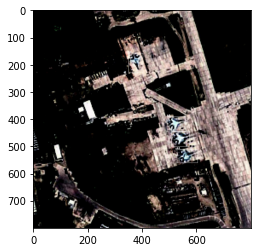

In [ ]:
random.seed(0)
annotations = [os.path.join('drive/MyDrive/kursinis_1st step/Annotations/Labels/', x) for x in os.listdir('drive/MyDrive/kursinis_1st step/Annotations/Labels/') if x[-3:] == "txt"]

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("drive/MyDrive/kursinis_1st step/Annotations/Labels/", "drive/MyDrive/kursinis_1st step/Images/").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('drive/MyDrive/kursinis_1st step/Images/', x) for x in os.listdir('drive/MyDrive/kursinis_1st step/Images/')]
annotations = [os.path.join('drive/MyDrive/kursinis_1st step/Annotations/Labels/', x) for x in os.listdir('drive/MyDrive/kursinis_1st step/Annotations/Labels/') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

3042 3042


In [ ]:
!mkdir ./yolov5/images ./yolov5/labels ./yolov5/images/train ./yolov5/images/val ./yolov5/images/test ./yolov5/labels/train ./yolov5/labels/val ./yolov5/labels/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in tqdm(list_of_files):
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, './yolov5/images/train')
move_files_to_folder(val_images, './yolov5/images/val/')
move_files_to_folder(test_images, './yolov5/images/test/')
move_files_to_folder(train_annotations, './yolov5/labels/train/')
move_files_to_folder(val_annotations, './yolov5/labels/val/')
move_files_to_folder(test_annotations, './yolov5/labels/test/')

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 305/305 [00:00<00:00, 942.07it/s]


In [ ]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: ./images/train/
val: ./images/val/
test: ./images/test/

# number of classes
nc: 20

# class names
names: ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']
"""

with open("dataset.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
!rm -rf ./runs
!rm -rf ./wandb

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.9 MB 7.7 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168 kB 80.3 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168 kB 56.2 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166 kB 80.7 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166 kB 81.1 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162 kB 83.5 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162 kB 80.1 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

!wandb enabled

W&B enabled.


In [ ]:
!python ./yolov5/train.py --img 512 --batch 32 --epochs 40 --data ./dataset.yaml --weights yolov5s.pt

wandb: Currently logged in as: darkdude. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=./dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ‚úÖ
YOLOv5 üöÄ v7.0-4-g7398d2d Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=

In [ ]:
!python ./yolov5/detect.py --source ./yolov5/images/test/ --weights ./yolov5/runs/train/exp/weights/best.pt --conf 0.25

detect: weights=['./yolov5/runs/train/exp/weights/best.pt'], source=./yolov5/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 üöÄ v7.0-4-g7398d2d Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
image 1/305 /content/yolov5/images/test/1003.jpg: 640x640 1 A13, 10.5ms
image 2/305 /content/yolov5/images/test/1006.jpg: 640x640 2 A15s, 10.3ms
image 3/305 /content/yolov5/images/test/1011.jpg: 640x640 8 A19s, 10.4ms
image 4/305 /content/yolov5/images/test/1014.jpg: 640x640 8 A13s, 10.3ms
image 5/305 /content/yo

In [ ]:
from plots import plot_results
plot_results('./yolov5/runs/train/exp/results.csv')

In [ ]:
#DATA_DIR = Path('./yolov5/runs/detect/exp/')
DATA_DIR = Path('drive/MyDrive/kursinis_1st step/Model/yolov5/runs/detect/exp/')
img_list = list(DATA_DIR.glob('*.jpg'))
pickone = random.choice(img_list)
labelPath = str(pickone).replace("drive/MyDrive/kursinis_1st step/Model/yolov5/runs/detect/exp/", "drive/MyDrive/kursinis_1st step/Annotations/BoundingBoxes/").replace("jpg", "xml")
info_dict = extract_info_from_xml(labelPath)
for b in info_dict["bndbox"]:
  print("Actual plane type:", b["class"])

img = PIL.Image.open(pickone)
display(img)

NameError: ignored

In [3]:
# Define a function which will plot the convolutional filters
def plot_pred_images(nrows, ncols):
    sample_idx = 0
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(20, 8)
    for i, ax in enumerate(axes.flat):
        #DATA_DIR = Path('drive/MyDrive/kursinis_1st step/Images/')
        DATA_DIR = Path('drive/MyDrive/kursinis_1st step/Model/yolov5/runs/detect/exp/')
        #DATA_DIR = Path('drive/MyDrive/kursinis_mayb/Images/')
        #DATA_DIR = Path('drive/MyDrive/kursinis_mayb/Model/yolov5/runs/detect/exp/')
        img_list = list(DATA_DIR.glob('*.jpg'))
        pickone = random.choice(img_list)
        img = PIL.Image.open(pickone)
        ax.imshow(img, interpolation='nearest')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_aspect('auto')

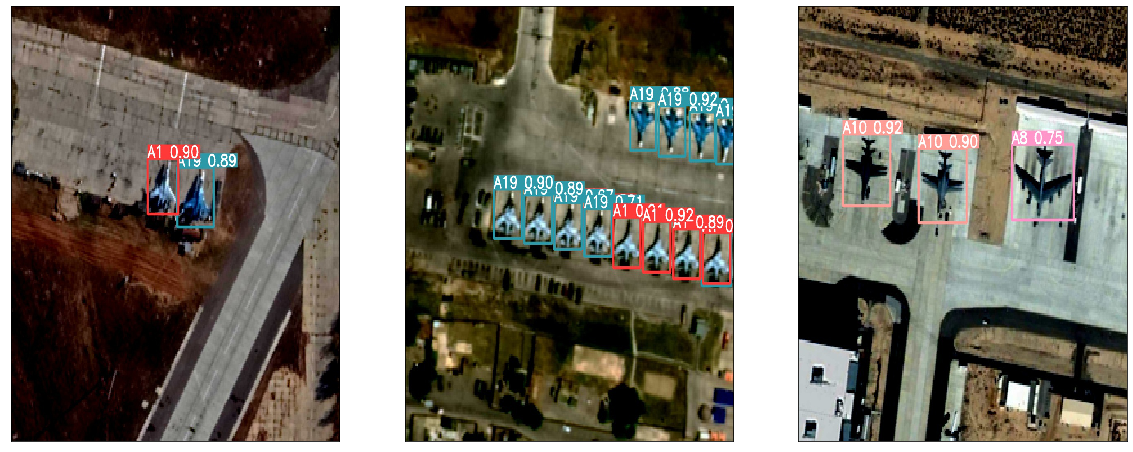

In [27]:
plot_pred_images(1, 3)